Metody rozpoznawania obrazów - zadanie 6

**Piotr Zawiślan**

**Konwolucje jednak niepotrzebne...**

Konwolucyjne sieci neuronowe działają bardzo dobrze w zadaniu rozpoznawania obrazów i przez długi czas królowały w benchmark-ach. W ostatnim czasie jednak, zrodziła się pewna rewolucja w podejściu do przetwarzania obrazów zainspirowana osiągnięciami z dziedziny przetwarzania języka naturalnego. Chodzi o tzw. Transformery, czyli sieci neuronowe z mechanizem uwagi - Self-Attention. Wykazano, że mechanizm ten może, całkowicie zastąpić konwolucje w zadaniach rozpoznawania obrazów. 

Dziś zaimplementujemy sobie takiego Transformera i zbadamy jego działanie.
- W przypadku punktów oznaczonych ikoną ⌨️ poinformuj w jaki sposób je zrealizowałeś - wspomnij kluczowe klasy/metody/funkcje lub załącz powiązany fragment kodu źródłowego.
- W przypadku punktów oznaczonych ikoną 🖼️ załącz w raporcie obraz przedstawiający efekt danej operacji.

In [1]:
import numpy as np
import pandas as pd
import torch
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
from time import perf_counter
from pathlib import Path

In [2]:
torch.cuda.is_available()

True

In [3]:
np.random.seed(311)
torch.manual_seed(311)

PLOTS_PATH = os.path.join(".", "plots")
os.makedirs(PLOTS_PATH, exist_ok=True)

In [4]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(PLOTS_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
def plot_image(image: torch.Tensor, title=None, save=False, fig_id=None, cmap='gray'):
    ndim = np.array(image.detach()).ndim
    
    if image.min().item() < 0:
        image = (image - image.min().item())  / (image - image.min().item() + image.max().item())
    
    if ndim == 2:
        plt.imshow(image.detach().numpy(), cmap=cmap)
    elif ndim == 3:
        if image.shape[0] == 1:
            plt.imshow(image[0].detach().numpy(), cmap=cmap)
        else:
            plt.imshow(np.moveaxis(image.detach().numpy(), 0, -1))
    else:
        return
    if title:
        plt.title(title)
    plt.axis("off")
    if save and fig_id is not None:
        save_fig(fig_id)
    plt.show()

In [6]:
LOSS_Y_LIM = (0., 2.5)
TIME_Y_LIM = (50., 80.)

def plot_train_stats(train_loss_list, train_acc_list, 
                     val_loss_list, val_acc_list, 
                     train_time_list,
                     fig_id=None):
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
    fig.subplots_adjust(hspace=0.4)
    fig.set_size_inches(12, 12)
    
    epochs_range = np.arange(0, len(train_loss_list))
    
    # Loss
    ax1.plot(epochs_range, train_loss_list, 'y.', label='train')
    ax1.plot(epochs_range, val_loss_list, 'c-', label='val')
    ax1.set_title("Loss")
    ax1.set_ylim(*LOSS_Y_LIM)
    ax1.grid()
    ax1.legend()
    
    # Accuracy
    ax2.plot(epochs_range, train_acc_list, 'b.', label='train')
    ax2.plot(epochs_range, val_acc_list, 'm-', label='val')
    ax2.set_title("Accuracy")
    ax2.set_ylim(-0.1, 1.1)
    ax2.grid()
    ax2.legend()
    
    # Time
    ax3.plot(epochs_range, train_time_list, 'g--')
    ax3.set_title("Training time")
    ax3.set_ylim(*TIME_Y_LIM)
    ax3.set_xlabel("epochs")
    ax3.grid()
    
    if fig_id is not None:
        save_fig(fig_id)
    plt.show()

# Przygotowanie danych

Do treningu użyjemy zbioru CIFAR-10 urozmaicając go za pomocą augmentacji. Augmentacja ma na celu zmniejszenie prawdopodobieństwa overfittingu. Modyfikujemy obrazy wycinając ich fragmenty, biorąc odbicie lustrzane i tym podobne operacje, aby urozmaicić zbiór i wprowadzić do niego nieregularności.

1. Przygotuj następującą sekwencję transformacji danych: `RandomHorizontalFlip` $\rightarrow$ `RandomResizedCrop` $\rightarrow$ `Normalize`. Opisz czego używasz. ⌨️

`RandomHorizontalFlip` - z prawdopodobieństwem 0.5 odwraca obraz przez oś y, tj. robi odbicie lustrzane (a nie odwraca do góry nogami).

`RandomResizedCrop` - wycina z obrazu losowy fragment i skaluje go z powrotem do wielkości oryginalnego obrazu. Rozmiar wycinka określ na przedział <0.8 - 1.0> wielkości oryginału, a aspect ratio między 0.9, a 1.1.

`Normalize` - zastosuj normalizację do średniej 0 i wariancji 1 (dla kadżdego kanału osobno). Do tej operacji wyciągnij wartości średniej i odchylenia standardowego ze zbioru treningowego.

2. Tak przygotowaną procedurę augmentacji przypnij w miejsce odpowiednie dla Twojego framework-a. Może to być Data Loader albo część modelu. Opisz jak to się robi w twoim framework-u. ⌨️
3. Pobierz, załaduj i przygotuj zbiór danych CIFAR-10 do treningu. (1 pkt.)

In [7]:
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import datasets
from torchvision.transforms import (
    Compose,
    Lambda,
    ToTensor,
    ConvertImageDtype,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Normalize
)

In [8]:
cifar_train_ds = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), 
                       ConvertImageDtype(torch.float)]),
    target_transform=Lambda(
        lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
    )
)

cifar_test_ds = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=Compose([ToTensor(), 
                       ConvertImageDtype(torch.float)]),
    target_transform=Lambda(
        lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
    )
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
cifar_train_ds[0][0].shape

torch.Size([3, 32, 32])

In [10]:
int_class_dict = {v: k for k, v in cifar_train_ds.class_to_idx.items()}

In [11]:
get_class_from_label: callable = lambda y: int_class_dict[torch.argmax(y).item()]

In [12]:
cifar_train_ds.transform

Compose(
    ToTensor()
    ConvertImageDtype()
)

In [13]:
cifar_train_ds.transform = Compose([
    ToTensor(),
    RandomHorizontalFlip(p=0.5),
    RandomResizedCrop(size=32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    Normalize(
        mean=tuple((cifar_train_ds.data / 255).mean(axis=(0, 1, 2))), 
        std=tuple((cifar_train_ds.data / 255).std(axis=(0, 1, 2)))
    ),
    ConvertImageDtype(torch.float)
])

In [14]:
cifar_test_ds.transform = Compose([
    ToTensor(),
    RandomHorizontalFlip(p=0.5),
    RandomResizedCrop(size=32, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    Normalize(
        mean=tuple((cifar_train_ds.data / 255).mean(axis=(0, 1, 2))), 
        std=tuple((cifar_train_ds.data / 255).std(axis=(0, 1, 2)))
    ),
    ConvertImageDtype(torch.float)
])

# Cięcie obrazu na fragmenty

Sieci typu transformer operują na zbiorach danych, np. na zdaniach złożonych z sekwencji słów, tworzących jedną zrozumiałą całość. Dzięki temu sieć podczas inferencji może kojarzyć ze sobą poszczególne elementy zbioru, tak aby wyciągnąć z nich sensowną wiedzę.

Aby użyć transformerów do przetwarzania obrazów musimy każdy obraz zamienić jakoś na sekwencję danych. W tym celu będziemy je kroić na kawałki (patch-e) i z tych kawałków robić sekwencję. Coś w stylu zamiany obrazu na zdanie.

4. Przygotuj procedurę zamieniającą batch obrazów na batch sekwencji patch-y. Opisz jej działanie. ⌨️

Poszczególne patch-e nie powinny na siebie nachodzić. Procedura powinna móc przygotować patch-e o dowolnym rozmiarze (ale kwadratowe), tj. jej argumentem powinien być rozmiar patch-a.

5. Przetestuj działanie procedury tnącej na patche, zwizualizuj wynik (wyświetl patch-e). 🖼️

In [15]:
def get_square_patches_from_batch(X: torch.Tensor, size: int) -> torch.Tensor:
    """Returns tensor of patches with shape [B, H // size, W // size, C, size, size]"""
    assert X.ndim == 4, 'ndim should be 4'
    batch_size, n_channels, n_rows, n_cols = X.shape
    step = size
    patches = X.unfold(2, size, step).unfold(3, size, step).permute(0, 2, 3, 1, 4, 5)
    return patches

In [16]:
bird = cifar_train_ds[6][0]

In [17]:
boat = cifar_train_ds[8][0]

In [18]:
bird_boat_batch = torch.cat([bird.unsqueeze(0), boat.unsqueeze(0)])
bird_boat_batch.shape

torch.Size([2, 3, 32, 32])

In [19]:
patches = get_square_patches_from_batch(
    bird_boat_batch,
    size=8
)
patches.shape

torch.Size([2, 4, 4, 3, 8, 8])

In [20]:
maybe_bird_patches = patches[0]

In [21]:
def plot_patches(image_patches: torch.Tensor, save=False, fig_id=None):
    assert image_patches.ndim == 5, 'image_patches ndim should be 5'
    
    n_patches_h, n_patches_w, _, size, _ = image_patches.shape
    fig, axs = plt.subplots(nrows=n_patches_h, ncols=n_patches_w, 
                            constrained_layout=True, figsize=(8, 8))
    
    for i in range(n_patches_h):
        for j in range(n_patches_w):
            image = np.moveaxis(image_patches[i, j].numpy(), 0, -1)
            if image.min().item() < 0:
                image = (image - image.min().item())  / \
                        (image - image.min().item() + image.max().item())
            axs[i, j].axis("off")
            axs[i, j].imshow(image)
    
    if save and fig_id is not None:
        save_fig(fig_id, tight_layout=False)
    
    plt.show()

Saving figure bird


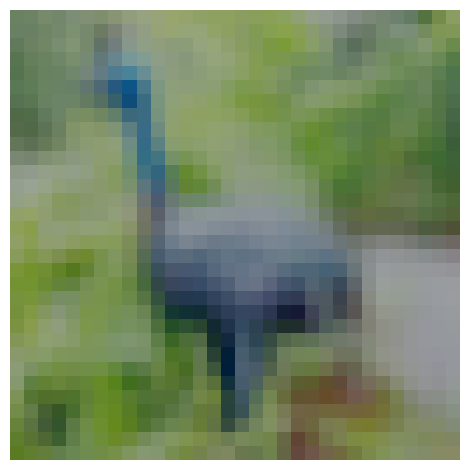

In [22]:
plot_image(bird, save=True, fig_id='bird')

Saving figure bird_patches


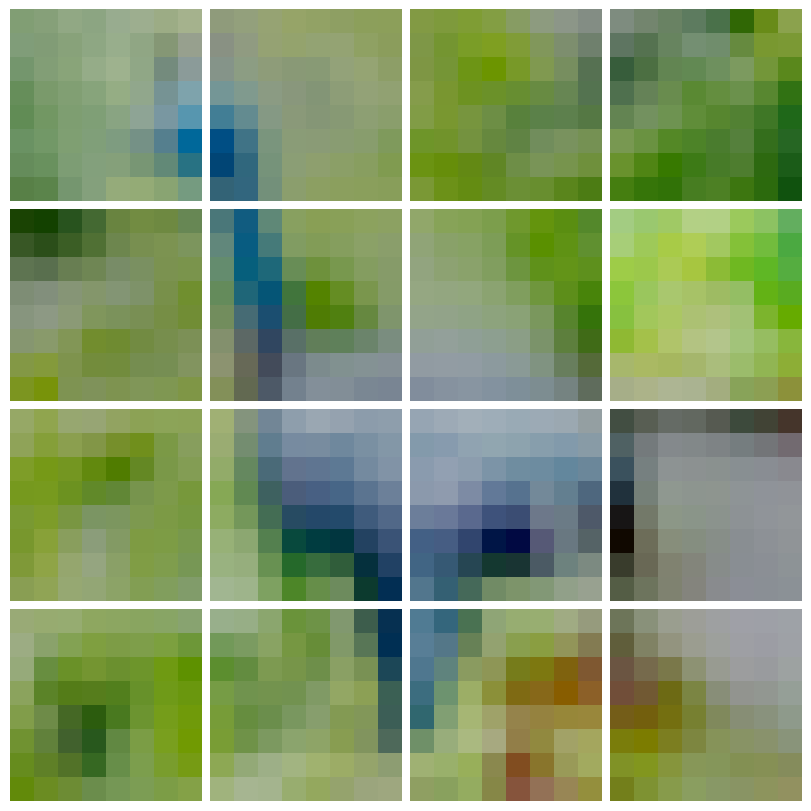

In [23]:
plot_patches(maybe_bird_patches, save=True, fig_id='bird_patches')

# Definicja modelu

Stworzymy sobie model Vision Transformera jak w artykule "An Image is Worth 16X16 Words", z jedną modyfikacją. Layer norm zastosujemy przed warstwami liniowymy, a nie po połączeniach rezydualnych. Schemat modelu powinien być taki jak na rysunku poniżej.

![](architektura.png)

6. Zdefiniuj model sieci według diagramu. Opisz w jaki sposób go tworzysz, jeśli się da wyświetl jego computation graph, dla pewności, że wszystko jest połączone jak należy. ⌨️ 🖼️

Do prawidłowej implementacji będziesz potrzebować warst typu: multihead attention, liniowych, layer norm, dropout. Oprócz tego potrzebne będą połączenia rezydualne, a jako funkcje aktywacji użyjemy GELU. Nie zapomnij także o dodatkowym tokenie na pozycji zerowej pełniącym funkcję class token-a. Na podstawie tego tokenu będzie wykonywana klasyfikacja.

Skorzystaj z gotowych implementacji warstwy multihead attention dostępnych w twoim framework-u.

Pierwszym krokiem w forward pass powinno być zamienianie obrazu na sekwencję patch-y o wielkości 4.

Patche należy zamienić na embeddingi przy pomocy warstwy liniowej. Wielkość tensora wyjściowego z embeddingu powinna wynosić 256. Do embeddingów patch-y dodaj positional embedding (tensor do nauczenia).

Każda warstwa ukryta (liniowa) w bloku transformera powinna mieć wielkość 512. Natomiast multihead-attention powinna mieć 8 "głów". Warstwa transformera na wejściu bierze tensor o wielkości 256 i na wyjściu też daje tensor o wielkości 256, czyli operuje na rozmiarze takim jaki ustaliliśmy dla embeddingu. W sumie potrzeba 6 bloków typu transfromer, jeden po drugim.

Ostatnim elementem modelu jest pojedyncza warstwa gęsta/liniowa (poprzedzona layer norm), która jest połączona jedynie z class token.

Wszystkim dropout-om ustaw prawdopodobieństwo zerowania połączeń na 0.2.

In [24]:
from torch import nn

In [25]:
class VisionTransformer(nn.Module):
    def __init__(self, emb_size=256, n_heads=8, dropout_rate=0.2) -> None:
        super().__init__()
        
        self.emb_size: int = emb_size
        self.n_heads: int = n_heads
        self.dropout_rate: float = dropout_rate
        
        self.layer_norm_1 = nn.LayerNorm(normalized_shape=self.emb_size)
        self.mh_attention = nn.MultiheadAttention(
            embed_dim=self.emb_size, 
            num_heads=self.n_heads,
            batch_first=True
        )
        
        self.layer_norm_2 = nn.LayerNorm(normalized_shape=self.emb_size)
        self.mlp_1 = nn.Linear(in_features=self.emb_size, out_features=2*self.emb_size)
        self.gelu = nn.GELU()
        self.dropout_1 = nn.Dropout(self.dropout_rate)
        
        self.mlp_2 = nn.Linear(in_features=2*self.emb_size, out_features=self.emb_size)
        self.dropout_2 = nn.Dropout(self.dropout_rate)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        X_norm = self.layer_norm_1(X)
        
        mh_attention_output, _ = self.mh_attention(
            query=X_norm,
            key=X_norm,
            value=X_norm
        )
        
        residual_add_1 = mh_attention_output + X
        
        X_mlp_1 = self.layer_norm_2(residual_add_1)
        X_mlp_1 = self.mlp_1(X_mlp_1)
        X_mlp_1 = self.gelu(X_mlp_1)
        result_mlp_1 = self.dropout_1(X_mlp_1)
        
        X_mlp_2 = self.mlp_2(result_mlp_1)
        result_mlp_2 = self.dropout_2(X_mlp_2)
        
        residual_add_2 = residual_add_1 + result_mlp_2
        
        return residual_add_2

In [26]:
vit_test = VisionTransformer()

In [27]:
test_X = torch.rand(32, 192, 256)

vit_test(test_X).shape

torch.Size([32, 192, 256])

In [28]:
class ToPatches(nn.Module):
    """
    Transforms image to flattened patches.
    
    [B, C, H, W] -> [B, H // size, W // size, C, size, size] ->
    [B, N (n_patches), P (size_of_flattened_patch)]
    """

    def __init__(self, patch_size=4) -> None:
        super().__init__()
        self.patch_size: int = patch_size

    def forward(self, X: torch.Tensor) -> torch.Tensor:        
        patches = get_square_patches_from_batch(X, size=self.patch_size)
        flat_patches = patches.flatten(start_dim=3).flatten(start_dim=1, end_dim=2)
        return flat_patches

In [29]:
class CifarViTClassifier(nn.Module):
    def __init__(
        self,
        n_classes=10,
        patch_size=4, 
        n_attention_heads=8,
        n_transformers=6,
        emb_size=256, 
        image_size=32, 
        dropout_rate=0.2
    ) -> None:
        
        super().__init__()
        
        self.n_classes: int = n_classes
        self.patch_size: int = patch_size
        self.n_attention_heads: int = n_attention_heads
        self.n_transformers: int = n_transformers
        self.emb_size: int = emb_size
        self.image_size: int = image_size
        self.dropout_rate: float = dropout_rate
        
        assert image_size % patch_size == 0, 'image_size should be divisible by patch_size'
        
        self.patch_dim: int = 3 * self.patch_size**2
        self.n_patches: int = (self.image_size // self.patch_size)**2
        
        # learnable parameters
        self.pos_embedding = nn.Parameter(torch.randn(1, self.n_patches + 1, self.emb_size))
        self.cls_token = nn.Parameter(torch.randn(1, 1, self.emb_size))
        
        # image -> patches -> patches_embedding
        self.to_patch_embedding = nn.Sequential(
            ToPatches(patch_size=self.patch_size),
            nn.Linear(in_features=self.patch_dim, out_features=self.emb_size)
        )
        
        self.input_dropout = nn.Dropout(p=self.dropout_rate)
        
        # self.n_transformers x transformers
        self.transformers_seq = nn.Sequential(*[
            VisionTransformer(
                emb_size=self.emb_size,
                n_heads=self.n_attention_heads,
                dropout_rate=self.dropout_rate
            ) for _ in range(self.n_transformers)
        ])
        
        # linear head
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(self.emb_size),
            nn.Linear(self.emb_size, self.n_classes)
        )


    def forward(self, X: torch.Tensor) -> torch.Tensor:
        batch_size = X.shape[0]
        embedded_patches = self.to_patch_embedding(X)
        
        
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        embedded_patches_with_cls = torch.cat((cls_tokens, embedded_patches), dim=1)
        embedded_patches_with_cls += self.pos_embedding

        trans_X = self.input_dropout(embedded_patches_with_cls)
        trans_output = self.transformers_seq(trans_X)
        
        cls_tokens_out = trans_output[:, 0, :]
        
        result = self.mlp_head(cls_tokens_out)
        return result

In [30]:
bird_boat_batch.shape

torch.Size([2, 3, 32, 32])

In [31]:
vit_classifier = CifarViTClassifier()

In [32]:
with torch.no_grad():
    print(vit_classifier(bird.unsqueeze(0)))

tensor([[ 0.0324,  0.7091,  0.1972, -0.4126,  0.3027, -0.2542, -0.2531,  0.6209,
          0.0287,  0.1389]])


In [33]:
vit_classifier

CifarViTClassifier(
  (to_patch_embedding): Sequential(
    (0): ToPatches()
    (1): Linear(in_features=48, out_features=256, bias=True)
  )
  (input_dropout): Dropout(p=0.2, inplace=False)
  (transformers_seq): Sequential(
    (0): VisionTransformer(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mh_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (layer_norm_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp_1): Linear(in_features=256, out_features=512, bias=True)
      (gelu): GELU(approximate=none)
      (dropout_1): Dropout(p=0.2, inplace=False)
      (mlp_2): Linear(in_features=512, out_features=256, bias=True)
      (dropout_2): Dropout(p=0.2, inplace=False)
    )
    (1): VisionTransformer(
      (layer_norm_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mh_attention): MultiheadAttention(
        (out_proj): NonD

# Trening

7. Wytrenuj tak przygotowaną sieć korzystając z poniższych ustawień. Puść 160 epok. (Jeżeli nie masz GPU, zredukuj ilość epok)

Aby przyspieszyć trening naszej sieci posłużymy się optimizer-em AdamW, który jest modyfikacą optimizer-a Adam. Użyjemy także learning rate scheduler, tj. procedurę, która w epoce nr 100 i 150 pomnoży learning rate o 0.1.

Jako loss function użyj Cross Entropy (categorical)

Na wyjściu z naszej sieci mamy wektor liczb. Największa z nich wyznacza klasę jaką sieć przypisuje obrazowi. Tzn. aby wyznaczyć indeks klasy obrazy należy wykonać operację argmax na wektorze wynikowym sieci.

*Jeżeli trenujesz na mniejszej liczbie epok zmodyfikuj milestone-y schedulera. Jeżeli twój framework nie udostępnia tego typu LR schedulera to użyj innego, możliwie podobnego.*

8. Przedstaw wyniki wytrenowanej sieci. Oprócz podania wyniku liczbowego sprawdź na kilku przykładowych obrazach. ⌨️ 🖼️

In [34]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import MultiStepLR

In [35]:
def train_step(
    model: nn.Module, 
    data_loader: DataLoader, 
    loss_fn: nn.CrossEntropyLoss, 
    optimizer
) -> None:
    
    num_batches = len(data_loader)
    epoch_loss = 0.
    epoch_correct_preds = 0
    model.train()
    t_start = perf_counter()
    
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to('cuda'), y.to('cuda')
        optimizer.zero_grad()
        prediction = model(X)
        assert prediction.shape == y.shape, \
            f"prediction [{prediction.shape}] and y [{y.shape}] shapes does not match"
        loss = loss_fn(prediction, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        correct_preds = (prediction.argmax(dim=1) == y.argmax(dim=1)).count_nonzero().item()
        epoch_correct_preds += correct_preds
    
    t_end = perf_counter()
    epoch_train_time = t_end - t_start
    epoch_avg_loss = epoch_loss / num_batches
    epoch_avg_acc = epoch_correct_preds / (num_batches * data_loader.batch_size)
    
    return epoch_avg_loss, epoch_avg_acc, epoch_train_time

In [36]:
def val_step(
    model: nn.Module, 
    data_loader: DataLoader, 
    loss_fn: nn.CrossEntropyLoss
) -> None:
    
    num_batches = len(data_loader)
    epoch_loss = 0.
    epoch_correct_preds = 0
    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to('cuda'), y.to('cuda')
            prediction = model(X)
            assert prediction.shape == y.shape, \
                f"prediction [{prediction.shape}] and y [{y.shape}] shapes does not match"
            loss = loss_fn(prediction, y)
            epoch_loss += loss.item()
            correct_preds = (prediction.argmax(dim=1) == y.argmax(dim=1)).count_nonzero().item()
            epoch_correct_preds += correct_preds
        
        epoch_avg_loss = epoch_loss / num_batches
        epoch_avg_acc = epoch_correct_preds / (num_batches * data_loader.batch_size)
        
        return epoch_avg_loss, epoch_avg_acc

In [35]:
vit_model = CifarViTClassifier().to('cuda')
vit_model.requires_grad_(True)

loss_function = nn.CrossEntropyLoss().cuda()

optimizer = AdamW(
    vit_model.parameters(),
    lr=5e-4
)

lr_scheduler = MultiStepLR(
    optimizer=optimizer,
    milestones=[100, 150],
    gamma=0.1
)

train_data_loader = DataLoader(cifar_train_ds, batch_size=64, shuffle=True)
test_data_loader = DataLoader(cifar_test_ds, batch_size=64, shuffle=True)

train_loss_acc_time_list = []
val_loss_acc_list = []

max_test_acc = 0.
early_stopped_vit_model = CifarViTClassifier().to('cuda')
early_stopped_vit_model.load_state_dict(vit_model.state_dict())

n_epochs = 160

for epoch in range(n_epochs):
    avg_train_loss, avg_train_acc, epoch_train_time = train_step(
        vit_model, 
        train_data_loader,
        loss_function,
        optimizer
    )
    
    avg_val_loss, avg_val_acc = val_step(
        vit_model, 
        test_data_loader,
        loss_function
    )
    
    lr_scheduler.step()
    
    train_loss_acc_time_list.append((avg_train_loss, avg_train_acc, epoch_train_time))
    val_loss_acc_list.append((avg_val_loss, avg_val_acc))
    
    if avg_val_acc > max_test_acc:
        max_test_acc = avg_val_acc
        early_stopped_vit_model.load_state_dict(vit_model.state_dict())
    
    if i % 10 == 0:
        print('='*16 + f" epoch {epoch:0>3} " + '='*16)
        print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.4f}", end=' ')
        print(f"train_time: {epoch_train_time:.2f} s")
        print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.4f}")
    
    if epoch in (10, 25, 50, 100, 125):
        torch.save(vit_model.state_dict(), Path.cwd() / f'vit-cifar10-{epoch}.pt')

print('='*16 + f" training ended " + '='*16)
print(f"Train | acc: {avg_train_acc:.3f} loss: {avg_train_loss:.4f}", end=' ')
print(f"train_time: {epoch_train_time:.2f} s")
print(f"Val | acc: {avg_val_acc:.3f} loss: {avg_val_loss:.4f}")

================ epoch 000 ================
Train | acc: 0.405 loss: 1.6297 train_time: 66.36 s
Val | acc: 0.481 loss: 1.4140
================ epoch 010 ================
Train | acc: 0.649 loss: 0.9825 train_time: 62.84 s
Val | acc: 0.644 loss: 0.9959
================ epoch 020 ================
Train | acc: 0.737 loss: 0.7383 train_time: 63.26 s
Val | acc: 0.701 loss: 0.8414
================ epoch 030 ================
Train | acc: 0.801 loss: 0.5558 train_time: 63.83 s
Val | acc: 0.736 loss: 0.7618
================ epoch 040 ================
Train | acc: 0.846 loss: 0.4256 train_time: 65.14 s
Val | acc: 0.749 loss: 0.7755
================ epoch 050 ================
Train | acc: 0.884 loss: 0.3233 train_time: 65.13 s
Val | acc: 0.754 loss: 0.7950
================ epoch 060 ================
Train | acc: 0.910 loss: 0.2478 train_time: 65.00 s
Val | acc: 0.751 loss: 0.8632
================ epoch 070 ================
Train | acc: 0.930 loss: 0.1921 train_time: 65.16 s
Val | acc: 0.751 loss:

In [36]:
# torch.save(vit_model.state_dict(), Path.cwd() / 'vit-cifar10-160.pt')

In [39]:
train_loss_list, train_acc_list, train_time_list = \
    list(zip(*train_loss_acc_time_list))

val_loss_list, val_acc_list = list(zip(*val_loss_acc_list))

Saving figure training_stats


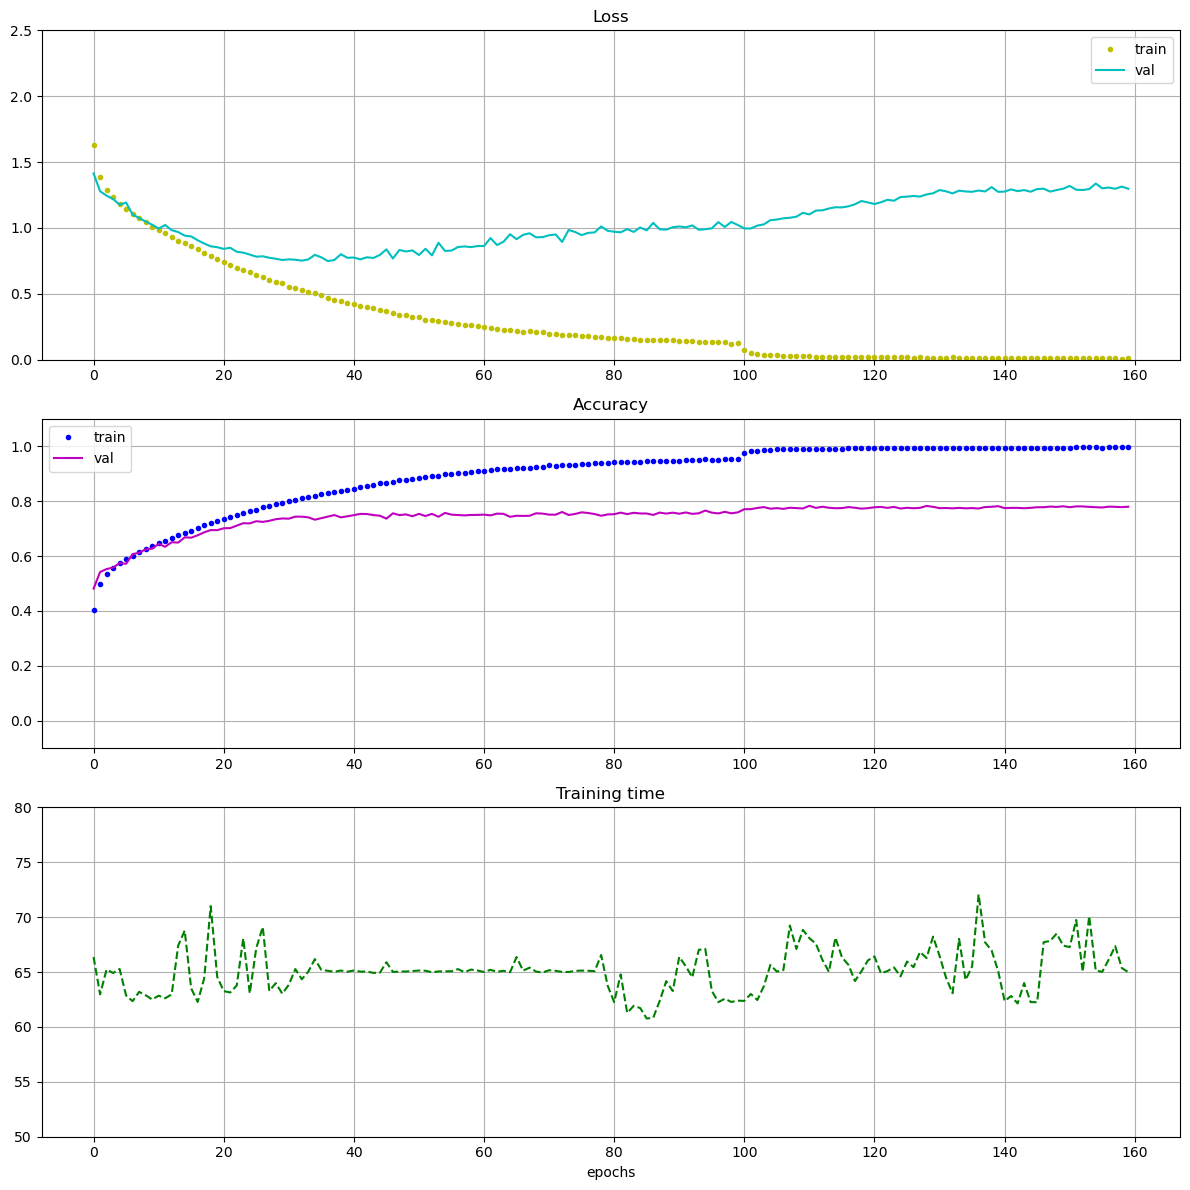

In [40]:
plot_train_stats(train_loss_list, train_acc_list, 
                 val_loss_list, val_acc_list, 
                 train_time_list,
                 fig_id='training_stats')

In [110]:
with torch.no_grad():
    print(vit_model(bird.unsqueeze(0).to('cuda')))

tensor([[-1.8534, -1.3578, 17.2570, -5.7278, -0.9811, -0.5323, -0.8393,  2.3303,
         -6.7388, -7.8683]], device='cuda:0')


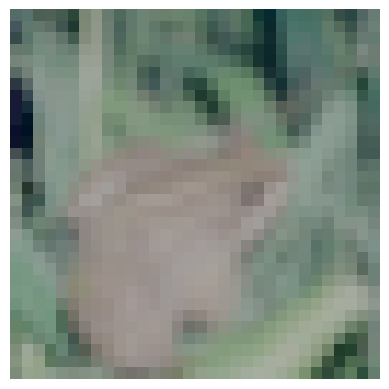

frog
frog


In [50]:
frog, y = cifar_test_ds[4]
plot_image(frog)
print(get_class_from_label(y))
with torch.no_grad():
    pred = vit_model(frog.unsqueeze(0)).flatten()
    print(get_class_from_label(pred))

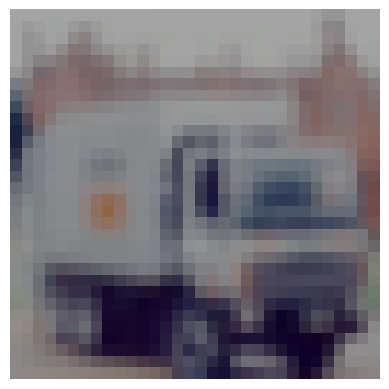

truck
truck


In [52]:
truck, y = cifar_test_ds[11]
plot_image(truck)
print(get_class_from_label(y))
with torch.no_grad():
    pred = vit_model(truck.unsqueeze(0)).flatten()
    print(get_class_from_label(pred))

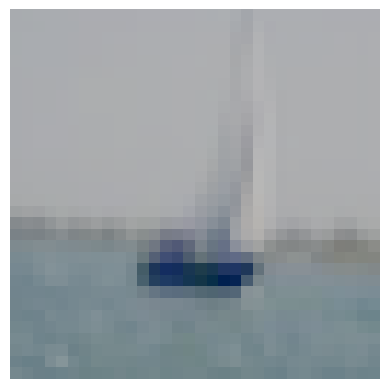

ship
ship


In [53]:
sailboat, y = cifar_test_ds[55]
plot_image(sailboat)
print(get_class_from_label(y))
with torch.no_grad():
    pred = vit_model(sailboat.unsqueeze(0)).flatten()
    print(get_class_from_label(pred))

9. [Bonus dla zainteresowanych, + 5 pkt] Zwizualizuj uwagę sieci na wybranym obrazku przy pomocy metody Attention Rollout. Opisz jak to działa. ⌨️ 🖼️

In [37]:
vit_model_state_dict = torch.load('vit-cifar10-160.pt')
vit_model = CifarViTClassifier()
vit_model.requires_grad_(False)
vit_model.load_state_dict(vit_model_state_dict)
vit_model.eval()
pass

In [38]:
vit_model_clone = CifarViTClassifier()
vit_model_clone.requires_grad_(False)
vit_model_clone.load_state_dict(vit_model.state_dict())
vit_model_clone.eval()
pass

In [39]:
def get_mha_matrix_from_nth_transformer(
    vit_m: CifarViTClassifier, 
    n: int,
    image: torch.Tensor
) -> torch.Tensor:
    """Get multi-head attention matrix from nth transformer using a forward hook."""
    
    result_activation = None
    
    def output_hook(model, _input, _output_tuple):
        nonlocal result_activation
        result_activation = _output_tuple[1].detach()
    
    handle = vit_m.transformers_seq[n].mh_attention.register_forward_hook(output_hook)

    _ = vit_m(image.unsqueeze(0))
    
    handle.remove()
    
    return result_activation.squeeze()

In [40]:
bird_attention = get_mha_matrix_from_nth_transformer(vit_model_clone, 0, bird)
bird_attention.shape

torch.Size([65, 65])

In [41]:
def get_patches_attention_map(
    vit_m: CifarViTClassifier,
    image: torch.Tensor
) -> torch.Tensor:
    
    att_map = get_mha_matrix_from_nth_transformer(vit_m, 0, image)
    for i in range(1, vit_m.n_transformers):
        ith_att_map = get_mha_matrix_from_nth_transformer(vit_m, i, image)
        att_map = att_map.T @ ith_att_map
    
    return att_map

In [42]:
bird_att_map = get_patches_attention_map(vit_model, bird)

In [43]:
bird_att_map

tensor([[0.0282, 0.0366, 0.0308,  ..., 0.0302, 0.0266, 0.0478],
        [0.0087, 0.0113, 0.0095,  ..., 0.0093, 0.0082, 0.0148],
        [0.0112, 0.0146, 0.0123,  ..., 0.0120, 0.0106, 0.0191],
        ...,
        [0.0162, 0.0211, 0.0177,  ..., 0.0174, 0.0153, 0.0275],
        [0.0111, 0.0144, 0.0121,  ..., 0.0119, 0.0104, 0.0188],
        [0.0089, 0.0115, 0.0097,  ..., 0.0095, 0.0084, 0.0150]])

Saving figure bird_attention_matrix


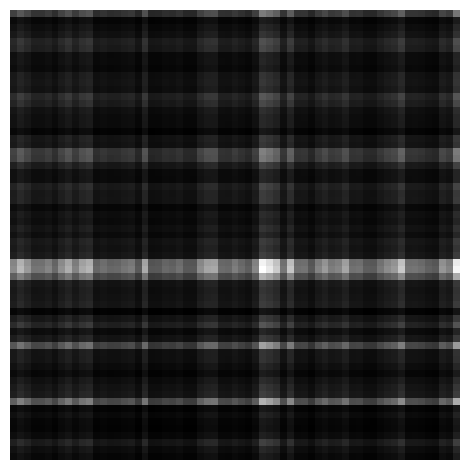

In [44]:
plot_image(bird_att_map, save=True, fig_id='bird_attention_matrix')

In [54]:
sailboat_att_map = get_patches_attention_map(vit_model, sailboat)

Saving figure sailboat_attention_matrix


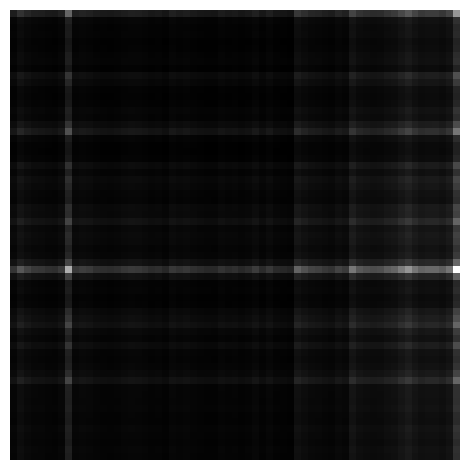

In [55]:
plot_image(sailboat_att_map, save=True, fig_id='sailboat_attention_matrix')

In [56]:
truck_att_map = get_patches_attention_map(vit_model, truck)

In [57]:
frog_att_map = get_patches_attention_map(vit_model, frog)

In [58]:
from torchvision.transforms.functional import resize

In [59]:
frog_att_map.shape

torch.Size([65, 65])

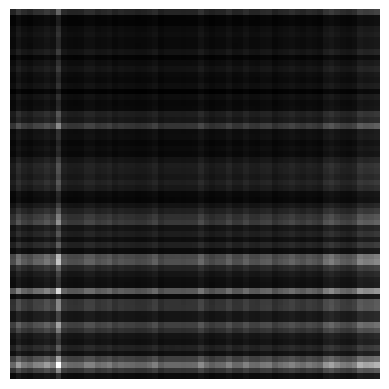

In [60]:
plot_image(frog_att_map)

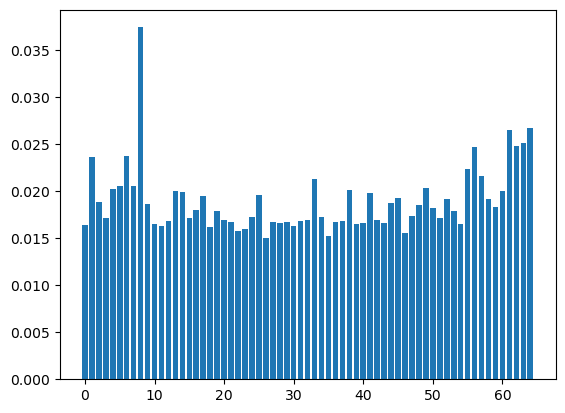

In [65]:
plt.bar(np.arange(65), list(frog_att_map[0, :]))
plt.show()

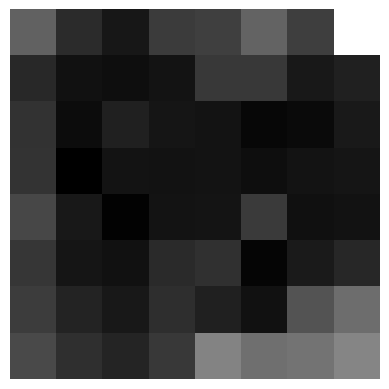

In [70]:
plot_image(frog_att_map[0, 1:].reshape(8, 8))

In [75]:
import torchvision

In [106]:
def plot_image_with_attention(
    image: torch.Tensor,
    att_matrix: torch.Tensor,
    fig_id=None
) -> None:
    
    image = torch.clone(image)
    att_matrix = torch.clone(att_matrix)
    
    im_size = image.shape[-1]
    n_patches = att_matrix.shape[-1] - 1
    assert im_size % np.sqrt(n_patches) == 0
    patch_size = im_size // int(np.sqrt(n_patches))
    
    if image.min().item() < 0:
        image = (image - image.min().item())  / (image - image.min().item() + image.max().item())
    
    plt.figure(figsize=(12, 6))
    
    # plot original image
    plt.subplot(121)
    plt.axis("off")
    plt.title('Original image')
    plt.imshow(np.moveaxis(image.detach().numpy(), 0, -1))
    
    plt.subplot(122)
    plt.axis("off")
    plt.title('Attention map')
    
    #  plot attention with regard to cls token
    enlarged_attention_map = att_matrix[0, 1:].reshape(
        int(np.sqrt(n_patches)), int(np.sqrt(n_patches))
    )
    enlarged_attention_map = resize(
        enlarged_attention_map.unsqueeze(0), size=(im_size, im_size),
        interpolation=torchvision.transforms.InterpolationMode.NEAREST
    ).squeeze()
    plt.imshow(np.moveaxis(enlarged_attention_map.detach().numpy(), 0, -1), cmap='jet')

    if fig_id is not None:
        save_fig(fig_id)
    plt.show()

Saving figure bird_attention_map


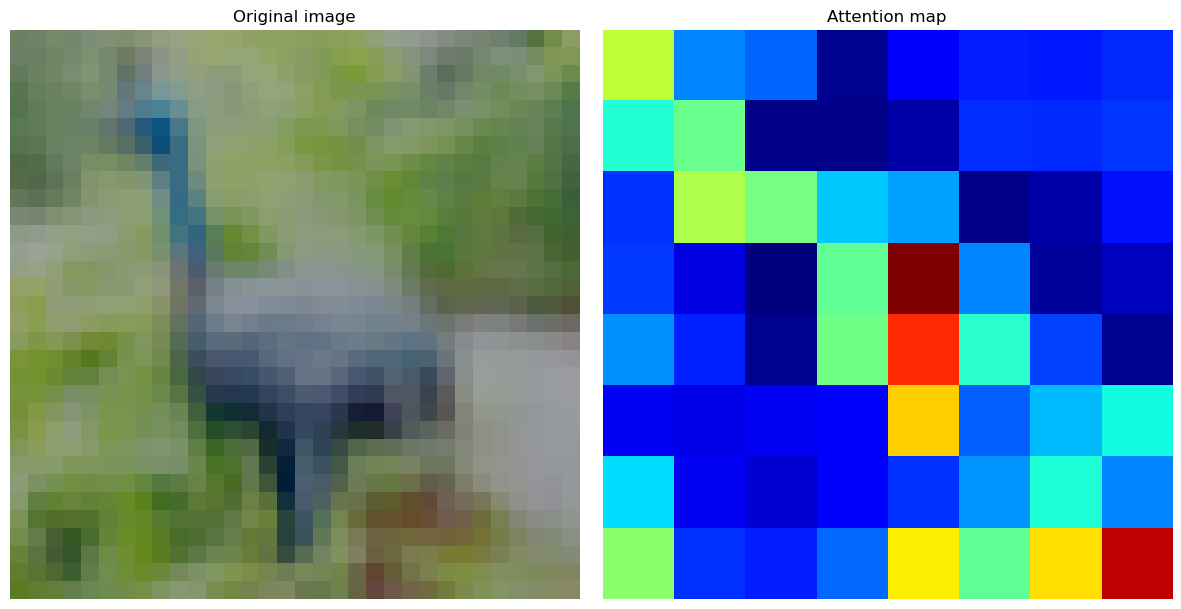

In [107]:
plot_image_with_attention(bird, bird_att_map, fig_id='bird_attention_map')

Saving figure sailboat_attention_map


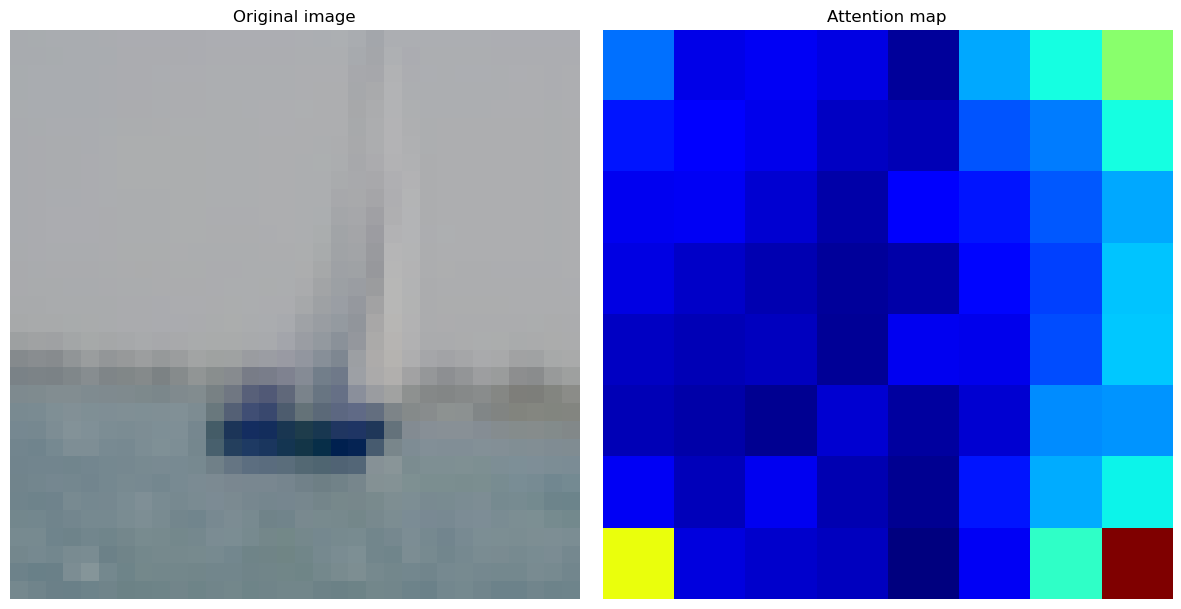

In [108]:
plot_image_with_attention(sailboat, sailboat_att_map, fig_id='sailboat_attention_map')

Saving figure truck_attention_map


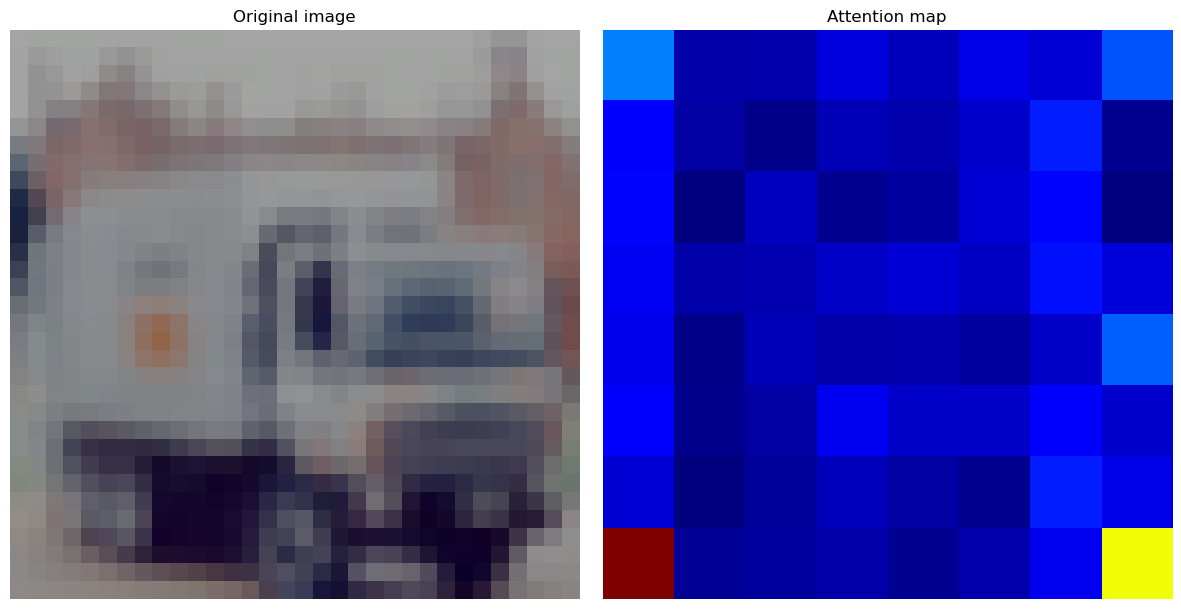

In [109]:
plot_image_with_attention(truck, truck_att_map, fig_id='truck_attention_map')

Saving figure frog_attention_map


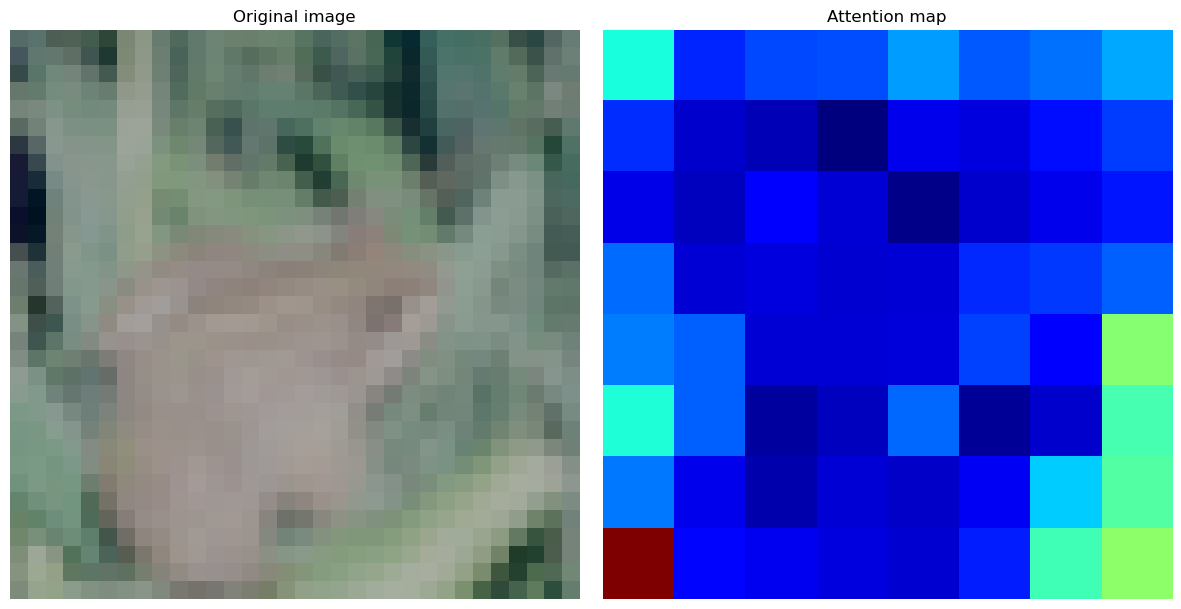

In [110]:
plot_image_with_attention(frog, frog_att_map, fig_id='frog_attention_map')